In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import pmdarima as pm
import torch

In [2]:
df = pd.read_csv("ILI_estimate.csv")
df.head()

/tmp/ipykernel_69689/3199957443.py:1: DtypeWarning: Columns (9,22,28,52,56,60,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ILI_estimate.csv")


,Unnamed: 0,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,...,Other Adverse Effects,Adverse Events,Did the patient get well?,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex
0,22,64f1f433b2767d0028a35601,2023-08-27T00:00:00+08:00,Outpatient,Check-up,60 - 69,False,6512-GBLYPkL4hA,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-01T00:00:00+08:00,NaN,6512,Female
1,35,64b46258713e280028a2ecdc,2023-07-04T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,5545-nCx5EGKwQL,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-07-17T00:00:00+08:00,NaN,5545,NaN
2,78,64a3383e915942002861d1c4,2023-07-01T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,5134-1DbSktQDNh,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-07-04T00:00:00+08:00,NaN,5134,Female
3,92,64f41b05c8efaa00299598da,2023-08-31T00:00:00+08:00,Outpatient,Check-up,10 - 19,False,6626-uCq62jAtEW,False,NaN,...,NaN,|,NaN,| | | Did the patient get well:,NaN,NaN,2023-09-03T00:00:00+08:00,NaN,6626,Male
4,96,64e748ff7795bc0028ed8a78,2023-07-28T00:00:00+08:00,Outpatient,New health issue,0 - 9,False,6104-RiFZTwxhKs,False,NaN,...,NaN,|,NaN,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-08-24T00:00:00+08:00,NaN,6104,Female


<Axes: >

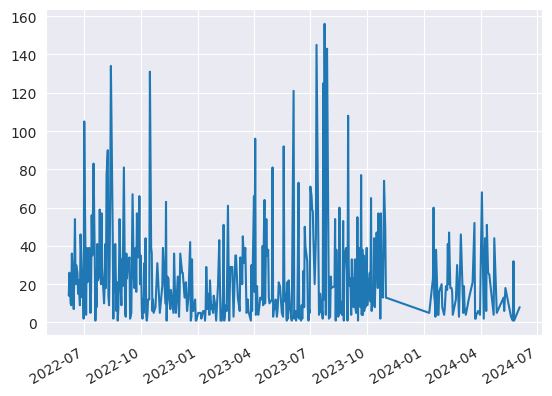

In [3]:
df['Date of Encounter'] = pd.to_datetime(df['Date of Encounter'])
df['Date of Encounter'].value_counts().sort_index().plot() 

In [4]:
year = df['Date of Encounter'].dt.isocalendar().year.astype(str)
week = df['Date of Encounter'].dt.isocalendar().week.astype(str)
df['year'] = year
df['week'] = week
df['year-week'] = year + "-" + week

def convert_to_date(year_week):
    year, week = map(int, year_week.split('-'))
    # Convert week to month assuming each month has 4 weeks
    month = int((week - 1) / 4) + 1
    return f'{year}-W{week:02d}-MONTH{month:02d}'

In [5]:
baseline_df = df[df['year'].isin(['2021','2022','2023'])]

<Axes: >

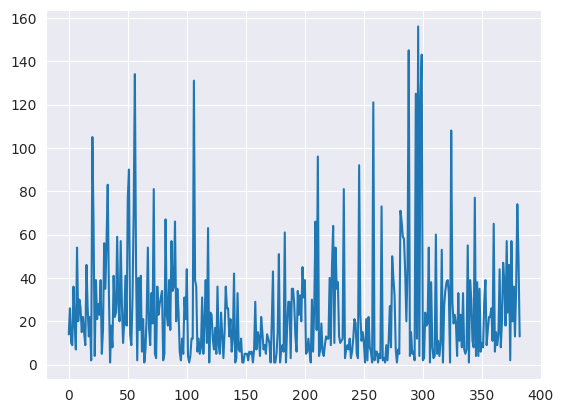

In [6]:
weekly = baseline_df['Date of Encounter'].value_counts().sort_index().reset_index()
weekly.columns = ['Date of Encounter','count']
weekly['count'].plot()

In [7]:
year = weekly['Date of Encounter'].dt.isocalendar().year.astype(str)
week = weekly['Date of Encounter'].dt.isocalendar().week.astype(str)
weekly['year'] = year
weekly['week'] = week
weekly['year-week'] = year + "-" + week


weekly.head()

,Date of Encounter,count,year,week,year-week
0,2022-06-06 00:00:00+08:00,14,2022,23,2022-23
1,2022-06-07 00:00:00+08:00,26,2022,23,2022-23
2,2022-06-09 00:00:00+08:00,10,2022,23,2022-23
3,2022-06-10 00:00:00+08:00,9,2022,23,2022-23
4,2022-06-11 00:00:00+08:00,36,2022,23,2022-23


In [8]:
weekly['week'] = weekly['year-week'].apply(convert_to_date)
weekly.set_index('week', inplace=True)

weekly.head()

,Date of Encounter,count,year,year-week
week,,,,
2022-W23-MONTH06,2022-06-06 00:00:00+08:00,14,2022,2022-23
2022-W23-MONTH06,2022-06-07 00:00:00+08:00,26,2022,2022-23
2022-W23-MONTH06,2022-06-09 00:00:00+08:00,10,2022,2022-23
2022-W23-MONTH06,2022-06-10 00:00:00+08:00,9,2022,2022-23
2022-W23-MONTH06,2022-06-11 00:00:00+08:00,36,2022,2022-23


In [9]:
model = pm.auto_arima(
    weekly['count'], 
    start_p = 1,
    start_q = 1,
    max_p = 12,
    max_q = 12,
    seasonal = True,
    trace = True,
    m = 52
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=10.99 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3586.616, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3589.151, Time=2.93 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3589.245, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3827.294, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3588.172, Time=2.74 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=3588.106, Time=1.87 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.47 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3587.726, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3587.880, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=3580.564, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=3582.168, Time=14.69 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=3581.945, Time=3.89 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3582.613, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[52] in

In [10]:
def detect_changes(df, threshold, arima_model):
    mean_ = df['count'].mean()
    dev_  = df['count'].std()

    df["warning_cusum"] = None
    df["warning_c1"] = None
    df["warning_c2"] = None
    df["warning_arima"] = None

    # Initialize C1 and C2
    df['C1'] = 0.0
    df['C2'] = 0.0

    counter = 0

    for i, row in df.iterrows():
        change_ = max(0, row["count"] - mean_)
        if change_ > threshold * dev_:
            df.at[i,"warning_cusum"] = 1
        else:
            df.at[i,"warning_cusum"] = 0

        # Calculate C1 and C2
        df.at[i, 'C1'] = max(0, row["count"] - mean_ + (df.at[prev_idx, 'C1'] if counter > 0 else 0))
        df.at[i, 'C2'] = max(0, mean_ - row["count"] + (df.at[prev_idx, 'C2'] if counter > 0 else 0))

        # Detect changes for C1 and C2
        df.at[i, 'warning_c1'] = (df.at[i, 'C1'] > threshold * dev_).astype(int)
        df.at[i, 'warning_c2'] = (df.at[i, 'C2'] > threshold * dev_).astype(int)

        prev_idx = i

        counter += 1

    df['predicted'] = arima_model.predict_in_sample()

    df['warning_arima'] = (df['count'] - df['predicted'] > threshold * np.std(df['count'] - df['predicted'])).astype(int)

    return df

In [11]:
weekly_ = detect_changes(weekly, threshold = 1, arima_model = model)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
weekly

In [ ]:
weekly_.head()

In [ ]:
weekly_.describe()

In [ ]:
model.summary()

In [ ]:
def plot_changes(df, warnings):
    plt.figure(figsize=(10, 6))

    plt.plot(df['count'], label='Count')

    colors = {'warning_cusum': 'red', 'warning_c1': 'green', 'warning_c2': 'purple', 'warning_arima': 'blue'}
    labels = {'warning_cusum': 'Change detected by Cumulative Sum Control', 'warning_c1': 'Change detected by C1', 'warning_c2': 'Change detected by C2', 'warning_arima': 'Change detected by ARIMA'}
    markers = {'warning_cusum': 'o', 'warning_c1': 'o', 'warning_c2': 's', 'warning_arima': 'x'}

    for warning in warnings:
        change_points = df[df[warning]==1]
        plt.scatter(change_points.index, change_points['count'], color=colors[warning], label=labels[warning], marker=markers[warning])

    # Set the x-ticks to the weeks where a change was detected by the selected warnings
    change_points_indices = set()
    for warning in warnings:
        change_points_indices = change_points_indices.union(set(df[df[warning]==1].index.values))
    plt.xticks(list(change_points_indices))

    #plt.xticks([])

    # Add labels and title
    plt.xlabel('Week')
    plt.ylabel('Count')
    plt.title('Influenza-Like Illnesses Warning Levels')

    # Add a legend
    plt.legend()

    plt.xticks(rotation=75)

    # Display the plot
    plt.show()

In [ ]:
# Use the function
plot_changes(weekly_, ['warning_cusum', 'warning_arima'])